In [7]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(4575, 5)
means:  [-0.00872321  0.00444568  3.14011483  0.19929218  0.20043479]
vars:  [0.26627299 0.2677912  1.81480141 0.05737896 0.05760085]
2d_sphere : 
(4392, 4)
means:  [2.75008170e-03 6.42149609e-03 3.15556028e+00 1.00161050e-01]
vars:  [0.26640715 0.26215936 1.80700842 0.0287064 ]


In [3]:
print len(scenes_dataset_yaml)

2987


In [4]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=5,
    base_environment_type="planar_tabletop")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=5,
    base_environment_type="planar_tabletop")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size

Train batch size:  2987
Test batch size:  746


In [87]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/planar_tabletop_lines/realproj_context" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_lines_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.01, 'betas': [0.9, 0.99], 'weight_decay': 1E-4},
      "step_size": 200,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(1000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=200) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=200) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        pyro.get_param_store().save("best_on_test_save.pyro")
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if loss_test > 10000 or (i > 300 and cycles_since_improvement > 100):
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))
print "Done"

Iter: 0, Loss: 8495.947420, Loss_test: 2440.670744, Best test loss: 2440.670744, Time per step: 21.172532
Iter: 1, Loss: 2514.308599, Loss_test: 1310.585372, Best test loss: 1310.585372, Time per step: 8.800475
Iter: 2, Loss: 1276.684242, Loss_test: 978.893432, Best test loss: 978.893432, Time per step: 8.052834
Iter: 3, Loss: 862.505288, Loss_test: 679.769730, Best test loss: 679.769730, Time per step: 7.695330
Iter: 4, Loss: 738.940628, Loss_test: 245.519458, Best test loss: 245.519458, Time per step: 9.583933
Iter: 5, Loss: 243.845428, Loss_test: 489.414125, Best test loss: 245.519458, Time per step: 9.569305
Iter: 6, Loss: 494.598655, Loss_test: 360.281627, Best test loss: 245.519458, Time per step: 10.408130
Iter: 7, Loss: 371.219465, Loss_test: 206.479935, Best test loss: 206.479935, Time per step: 10.130886
Iter: 8, Loss: 213.780562, Loss_test: 250.252639, Best test loss: 206.479935, Time per step: 9.891304
Iter: 9, Loss: 287.224085, Loss_test: 142.131514, Best test loss: 142.13

Iter: 82, Loss: -14.066731, Loss_test: -15.855784, Best test loss: -15.855784, Time per step: 11.312294
Iter: 83, Loss: -15.196619, Loss_test: -16.495176, Best test loss: -16.495176, Time per step: 11.946217
Iter: 84, Loss: -16.239206, Loss_test: -15.701973, Best test loss: -16.495176, Time per step: 9.565761
Iter: 85, Loss: -15.199891, Loss_test: -17.174675, Best test loss: -17.174675, Time per step: 9.359286
Iter: 86, Loss: -15.645999, Loss_test: -18.556405, Best test loss: -18.556405, Time per step: 22.048419
Iter: 87, Loss: -18.512441, Loss_test: -17.643777, Best test loss: -18.556405, Time per step: 12.907230
Iter: 88, Loss: -17.826117, Loss_test: -18.330932, Best test loss: -18.556405, Time per step: 10.832200
Iter: 89, Loss: -20.060809, Loss_test: -15.922998, Best test loss: -18.556405, Time per step: 11.346428
Iter: 90, Loss: -17.298217, Loss_test: -20.283288, Best test loss: -20.283288, Time per step: 12.235172
Iter: 91, Loss: -21.960190, Loss_test: -20.457751, Best test loss:

Iter: 161, Loss: -16.643702, Loss_test: -18.751295, Best test loss: -22.414720, Time per step: 10.139039
Iter: 162, Loss: -19.160558, Loss_test: -14.913922, Best test loss: -22.414720, Time per step: 11.799342
Iter: 163, Loss: -15.461004, Loss_test: -17.582281, Best test loss: -22.414720, Time per step: 11.117837
Iter: 164, Loss: -18.574425, Loss_test: -17.922046, Best test loss: -22.414720, Time per step: 10.631824
Iter: 165, Loss: -18.836072, Loss_test: -16.350853, Best test loss: -22.414720, Time per step: 11.420633
Iter: 166, Loss: -19.815613, Loss_test: -19.057425, Best test loss: -22.414720, Time per step: 10.493025
Iter: 167, Loss: -19.222512, Loss_test: -14.449829, Best test loss: -22.414720, Time per step: 10.339652
Iter: 168, Loss: -15.556310, Loss_test: 35.007038, Best test loss: -22.414720, Time per step: 11.116018
Iter: 169, Loss: 36.430442, Loss_test: 0.082782, Best test loss: -22.414720, Time per step: 9.951517
Iter: 170, Loss: -0.076519, Loss_test: 28.051590, Best test 

Process PoolWorker-1459:
Process PoolWorker-1467:
Process PoolWorker-1454:
Process PoolWorker-1456:
Process PoolWorker-1470:
Process PoolWorker-1468:
Process PoolWorker-1462:
Process PoolWorker-1461:
Process PoolWorker-1458:
Process PoolWorker-1463:
Traceback (most recent call last):
Process PoolWorker-1457:
Process PoolWorker-1469:
Process PoolWorker-1464:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-1455:
Traceback (most recent call last):
Process PoolWorker-1465:
Process PoolWorker-1466:
Traceback (most recent call last):
Process PoolWorker-1452:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstr

    self._target(*self._args, **self._kwargs)
    task = get()
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
    self._target(*self._args, **self._kwargs)
    task = get()
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in g

KeyboardInterrupt: 

    racquire()
    task = get()
    racquire()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
    task = get()
    racquire()
    racquire()
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
KeyboardInterrupt
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
KeyboardInterrupt
KeyboardInterrupt
    return recv()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInte

In [8]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
pyro.get_param_store().load("best_on_test_save.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

print(model.class_flows[1][4].arn)
pyro.param("class_1_flow_4$$$arn.layers.0.bias")

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


('Loaded model evaluated on all of test: ', -23.01957314008043)
AutoRegressiveNN(
  (layers): ModuleList(
    (0): MaskedLinear(in_features=105, out_features=100, bias=True)
    (1): Dropout(p=0.0)
    (2): MaskedLinear(in_features=100, out_features=100, bias=True)
    (3): Dropout(p=0.0)
    (4): MaskedLinear(in_features=100, out_features=10, bias=True)
  )
  (f): ReLU()
)


Parameter containing:
tensor([-0.0378, -0.0672, -0.1037, -0.0161,  0.0368, -0.0261, -0.1152, -0.1402,
        -0.0182,  0.1081, -0.1691,  0.0186, -0.0040, -0.0732,  0.0211, -0.0145,
         0.0324, -0.0792,  0.0349, -0.0526, -0.0105,  0.0624,  0.0401, -0.1151,
        -0.0015,  0.0835, -0.0622,  0.0263, -0.0412, -0.0657, -0.0977, -0.0632,
        -0.1435, -0.0167, -0.0709, -0.0096,  0.0415, -0.0058,  0.2117, -0.1293,
        -0.1798, -0.0542, -0.0344,  0.0558, -0.0208, -0.0732,  0.0041, -0.0615,
        -0.0191, -0.0302,  0.0868,  0.0213, -0.1257, -0.1187,  0.0119,  0.0128,
        -0.0220, -0.0697,  0.0491, -0.1022,  0.0315,  0.0036, -0.0792,  0.0881,
        -0.0068,  0.0457,  0.0222,  0.0222, -0.0639, -0.1653, -0.0280,  0.0109,
        -0.1098, -0.0398, -0.1957, -0.0972,  0.0893, -0.0016,  0.0357, -0.1073,
        -0.0723, -0.1194,  0.0601, -0.1443,  0.0267, -0.1764, -0.0591,  0.1089,
         0.0896,  0.0495, -0.0952,  0.0201, -0.0594, -0.0458,  0.1046, -0.0093,
        -0.0876,  

In [11]:
cycles_since_improvement = 0
scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.0001, 'betas': [0.9, 0.99]},
      "step_size": 500,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)

losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

for i in range(2000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=20) / data.batch_size
    losses.append(loss)
#    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=20) / data_test.batch_size
    losses_test.append(loss_test)
#    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 200:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

Iter: 0, Loss: -25.984033, Loss_test: -28.957427, Best test loss: -28.957427, Time per step: 2.995550
Iter: 1, Loss: -21.635392, Loss_test: -24.438042, Best test loss: -28.957427, Time per step: 3.239313
Iter: 2, Loss: -23.997012, Loss_test: -19.716582, Best test loss: -28.957427, Time per step: 3.060334
Iter: 3, Loss: -20.374559, Loss_test: -24.485920, Best test loss: -28.957427, Time per step: 2.910409
Iter: 4, Loss: -28.126476, Loss_test: -25.126519, Best test loss: -28.957427, Time per step: 3.055082
Iter: 5, Loss: -21.878097, Loss_test: -28.033067, Best test loss: -28.957427, Time per step: 2.938972
Iter: 6, Loss: -24.229902, Loss_test: -21.544917, Best test loss: -28.957427, Time per step: 2.893412
Iter: 7, Loss: -25.634418, Loss_test: -29.889947, Best test loss: -29.889947, Time per step: 3.090538
Iter: 8, Loss: -28.593926, Loss_test: -21.563262, Best test loss: -29.889947, Time per step: 2.950561
Iter: 9, Loss: -30.320077, Loss_test: -24.532918, Best test loss: -29.889947, Time

Iter: 80, Loss: -37.562903, Loss_test: -27.849714, Best test loss: -36.714967, Time per step: 4.330615
Iter: 81, Loss: -27.644058, Loss_test: -29.309157, Best test loss: -36.714967, Time per step: 3.449380
Iter: 82, Loss: -26.436601, Loss_test: -26.931151, Best test loss: -36.714967, Time per step: 3.464883
Iter: 83, Loss: -32.348653, Loss_test: -27.657326, Best test loss: -36.714967, Time per step: 3.776080
Iter: 84, Loss: -33.173286, Loss_test: -23.127218, Best test loss: -36.714967, Time per step: 3.797303
Iter: 85, Loss: -30.034546, Loss_test: -28.058390, Best test loss: -36.714967, Time per step: 3.623583
Iter: 86, Loss: -29.079911, Loss_test: -34.357210, Best test loss: -36.714967, Time per step: 3.772119
Iter: 87, Loss: -31.694076, Loss_test: -23.742729, Best test loss: -36.714967, Time per step: 3.438248
Iter: 88, Loss: -33.082585, Loss_test: -33.085351, Best test loss: -36.714967, Time per step: 3.329738
Iter: 89, Loss: -29.117996, Loss_test: -29.458393, Best test loss: -36.71

Iter: 159, Loss: -29.579185, Loss_test: -30.830136, Best test loss: -38.482558, Time per step: 3.115708
Iter: 160, Loss: -30.344043, Loss_test: -21.135801, Best test loss: -38.482558, Time per step: 3.063515
Iter: 161, Loss: -26.347965, Loss_test: -31.069098, Best test loss: -38.482558, Time per step: 3.045152
Iter: 162, Loss: -34.246326, Loss_test: -29.192508, Best test loss: -38.482558, Time per step: 3.077224
Iter: 163, Loss: -29.952888, Loss_test: -28.190644, Best test loss: -38.482558, Time per step: 2.923973
Iter: 164, Loss: -33.017701, Loss_test: -29.695577, Best test loss: -38.482558, Time per step: 3.024637
Iter: 165, Loss: -27.685839, Loss_test: -33.197669, Best test loss: -38.482558, Time per step: 3.132457
Iter: 166, Loss: -31.587689, Loss_test: -20.002546, Best test loss: -38.482558, Time per step: 3.122048
Iter: 167, Loss: -29.749770, Loss_test: -28.010669, Best test loss: -38.482558, Time per step: 3.339678
Iter: 168, Loss: -32.497241, Loss_test: -27.974816, Best test lo

Iter: 238, Loss: -36.044980, Loss_test: -34.862695, Best test loss: -39.762153, Time per step: 3.095868
Iter: 239, Loss: -29.132715, Loss_test: -33.381383, Best test loss: -39.762153, Time per step: 2.951675
Iter: 240, Loss: -36.900021, Loss_test: -38.375969, Best test loss: -39.762153, Time per step: 3.156291
Iter: 241, Loss: -42.220760, Loss_test: -25.084566, Best test loss: -39.762153, Time per step: 3.278130
Iter: 242, Loss: -28.751497, Loss_test: -31.869104, Best test loss: -39.762153, Time per step: 2.983145
Iter: 243, Loss: -29.889416, Loss_test: -29.661450, Best test loss: -39.762153, Time per step: 3.072020
Iter: 244, Loss: -30.333243, Loss_test: -29.722106, Best test loss: -39.762153, Time per step: 3.097383
Iter: 245, Loss: -35.512460, Loss_test: -36.035648, Best test loss: -39.762153, Time per step: 3.110926
Iter: 246, Loss: -37.676444, Loss_test: -38.663633, Best test loss: -39.762153, Time per step: 3.060479
Iter: 247, Loss: -38.744934, Loss_test: -32.164023, Best test lo

Iter: 317, Loss: -32.242019, Loss_test: -30.562720, Best test loss: -41.682984, Time per step: 3.254848
Iter: 318, Loss: -30.530845, Loss_test: -29.846934, Best test loss: -41.682984, Time per step: 3.108998
Iter: 319, Loss: -36.119371, Loss_test: -34.815859, Best test loss: -41.682984, Time per step: 3.146470
Iter: 320, Loss: -40.717701, Loss_test: -37.735058, Best test loss: -41.682984, Time per step: 3.584459
Iter: 321, Loss: -32.490986, Loss_test: -31.941236, Best test loss: -41.682984, Time per step: 4.400794
Iter: 322, Loss: -34.513887, Loss_test: -37.294294, Best test loss: -41.682984, Time per step: 4.346397
Iter: 323, Loss: -35.082887, Loss_test: -33.993355, Best test loss: -41.682984, Time per step: 3.392192
Iter: 324, Loss: -34.777596, Loss_test: -31.839126, Best test loss: -41.682984, Time per step: 3.226919
Iter: 325, Loss: -33.215917, Loss_test: -34.748762, Best test loss: -41.682984, Time per step: 3.349314
Iter: 326, Loss: -36.933067, Loss_test: -30.418094, Best test lo

Iter: 396, Loss: -32.655308, Loss_test: -39.495434, Best test loss: -48.165283, Time per step: 3.143650
Iter: 397, Loss: -36.065586, Loss_test: -39.485464, Best test loss: -48.165283, Time per step: 3.204620
Iter: 398, Loss: -38.899762, Loss_test: -27.575394, Best test loss: -48.165283, Time per step: 3.058290
Iter: 399, Loss: -37.942094, Loss_test: -32.763211, Best test loss: -48.165283, Time per step: 3.155914
Iter: 400, Loss: -32.621623, Loss_test: -28.859828, Best test loss: -48.165283, Time per step: 3.175718
Iter: 401, Loss: -36.490595, Loss_test: -27.856961, Best test loss: -48.165283, Time per step: 3.216252
Iter: 402, Loss: -39.227893, Loss_test: -34.150896, Best test loss: -48.165283, Time per step: 3.427416
Iter: 403, Loss: -43.081266, Loss_test: -28.930968, Best test loss: -48.165283, Time per step: 3.113370
Iter: 404, Loss: -31.982168, Loss_test: -28.444121, Best test loss: -48.165283, Time per step: 3.066850
Iter: 405, Loss: -43.357942, Loss_test: -37.133616, Best test lo

Iter: 475, Loss: -41.590843, Loss_test: -37.167950, Best test loss: -48.165283, Time per step: 3.294465
Iter: 476, Loss: -36.331150, Loss_test: -33.756914, Best test loss: -48.165283, Time per step: 3.285396
Iter: 477, Loss: -39.320108, Loss_test: -35.816713, Best test loss: -48.165283, Time per step: 3.750925
Iter: 478, Loss: -38.078679, Loss_test: -29.917249, Best test loss: -48.165283, Time per step: 3.437389
Iter: 479, Loss: -37.992000, Loss_test: -41.268633, Best test loss: -48.165283, Time per step: 3.245551
Iter: 480, Loss: -40.120712, Loss_test: -32.562369, Best test loss: -48.165283, Time per step: 3.168299
Iter: 481, Loss: -34.622004, Loss_test: -33.665652, Best test loss: -48.165283, Time per step: 3.229530
Iter: 482, Loss: -38.409368, Loss_test: -37.353026, Best test loss: -48.165283, Time per step: 3.444366
Iter: 483, Loss: -35.959580, Loss_test: -36.760983, Best test loss: -48.165283, Time per step: 3.589026
Iter: 484, Loss: -29.216589, Loss_test: -29.733045, Best test lo

Iter: 554, Loss: -27.993600, Loss_test: -38.602903, Best test loss: -48.165283, Time per step: 3.411139
Iter: 555, Loss: -38.591151, Loss_test: -40.859249, Best test loss: -48.165283, Time per step: 3.591682
Iter: 556, Loss: -39.054685, Loss_test: -43.603442, Best test loss: -48.165283, Time per step: 3.201039
Iter: 557, Loss: -34.953692, Loss_test: -39.856568, Best test loss: -48.165283, Time per step: 3.285568
Iter: 558, Loss: -34.347092, Loss_test: -33.087537, Best test loss: -48.165283, Time per step: 3.092822
Iter: 559, Loss: -32.956199, Loss_test: -38.591915, Best test loss: -48.165283, Time per step: 2.996373
Iter: 560, Loss: -39.470240, Loss_test: -34.287033, Best test loss: -48.165283, Time per step: 3.031617
Iter: 561, Loss: -33.910434, Loss_test: -33.836765, Best test loss: -48.165283, Time per step: 2.947958
Iter: 562, Loss: -35.561398, Loss_test: -32.937783, Best test loss: -48.165283, Time per step: 3.142736
Iter: 563, Loss: -35.393786, Loss_test: -38.131522, Best test lo

Text(0.5,1,'Loses: final [-35.371640 train][-35.879128 test][-48.165283 best test]')

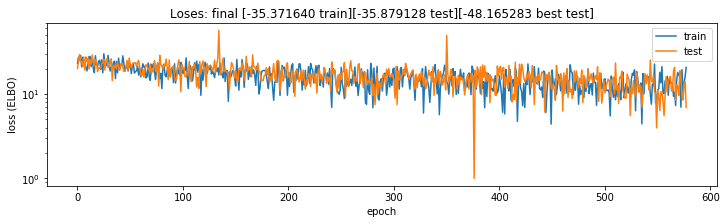

In [12]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test][%f best test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:]), best_test_loss))
#print("Model evaluated on all of test: ",
#      svi.evaluate_loss(data_test) / data_test.batch_size)

In [13]:
# Save model
pre_param_settings = {}
for name in pyro.get_param_store().get_all_param_names():
    pre_param_settings[name] = pyro.param(name).clone()

pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_lines_with_projection_hugenets.pyro")
#pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_stacks_with_projection_constraints.pyro")

In [6]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_lines_with_projection_hugenets.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test, subsample_size=100) / data_test.batch_size)

print(model.class_flows[1][4].arn)
pyro.param("class_1_flow_4$$$arn.layers.0.bias")

NameError: name 'Trace_ELBO' is not defined

In [ ]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_tabletop")
    time.sleep(1.0)

/home/gizatt/underactuated/src/underactuated/planar_multibody_visualizer.py:108: DrakeDeprecationWarning: '_DeclareAbstractInputPort' is deprecated and will be removed on or around 2019-06-15. Please call 'DeclareAbstractInputPort' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  AbstractValue.Make(PoseBundle(0)))
/home/gizatt/underactuated/src/underactuated/planar_multibody_visualizer.py:157: DrakeDeprecationWarning: Use pydrake.lcm.Subscriber instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  
/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/gizatt/miniconda3/

(2, ' patch ', array([[ 0.09720673,  0.09418481,  0.08530693,  0.07112509,  0.05252102,
         0.03065146,  0.00687613, -0.01732672, -0.04045227, -0.06106271,
        -0.07787655, -0.08984842, -0.09623394, -0.0966361 , -0.0910299 ,
        -0.0797639 , -0.06353856, -0.04336271, -0.02049077,  0.00365518,
         0.02757387,  0.04977816,  0.06888747,  0.0837137 ,  0.09333502,
         0.09715321,  0.09720673],
       [ 0.        ,  0.02404933,  0.04660339,  0.06625988,  0.08179665,
         0.0922477 ,  0.09696323,  0.09565006,  0.08838983,  0.07563395,
         0.05817552,  0.03710002,  0.01371782, -0.0105173 , -0.03409849,
        -0.05555961, -0.0735663 , -0.08699899, -0.09502251, -0.09713799,
        -0.0932139 , -0.08349422, -0.06858327, -0.04940815, -0.02716107,
        -0.00322524,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.  

(2, ' patch ', array([[ 0.07732899,  0.07492502,  0.06786257,  0.05658076,  0.04178103,
         0.02438356,  0.00547004, -0.01378359, -0.03218021, -0.04857603,
        -0.06195162, -0.07147537, -0.07655512, -0.07687504, -0.07241525,
        -0.06345302, -0.0505456 , -0.03449549, -0.01630063,  0.00290774,
         0.02193531,  0.03959905,  0.05480072,  0.06659514,  0.074249  ,
         0.07728641,  0.07732899],
       [ 0.        ,  0.0191315 ,  0.03707349,  0.05271044,  0.0650701 ,
         0.07338402,  0.07713528,  0.07609064,  0.07031505,  0.06016761,
         0.04627924,  0.02951346,  0.01091267, -0.00836662, -0.02712571,
        -0.04419826, -0.05852277, -0.06920862, -0.07559141, -0.0772743 ,
        -0.07415264, -0.06642053, -0.05455872, -0.03930471, -0.02160692,
        -0.00256572,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.  

(1, ' patch ', array([[-0.08576813,  0.08576813,  0.08576813, -0.08576813, -0.08576813,
         0.08576813,  0.08576813, -0.08576813, -0.08576813],
       [ 0.09140802,  0.09140802,  0.09140802,  0.09140802, -0.09140802,
        -0.09140802, -0.09140802, -0.09140802,  0.09140802],
       [ 0.125     ,  0.125     , -0.125     , -0.125     , -0.125     ,
        -0.125     ,  0.125     ,  0.125     ,  0.125     ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ]]))
(1, ' patch ', array([[-0.15210168,  0.15210168,  0.15210168, -0.15210168, -0.15210168,
         0.15210168,  0.15210168, -0.15210168, -0.15210168],
       [ 0.07219507,  0.07219507,  0.07219507,  0.07219507, -0.07219507,
        -0.07219507, -0.07219507, -0.07219507,  0.07219507],
       [ 0.125     ,  0.125     , -0.125     , -0.125     , -0.125     ,
        -0.125     ,  0.125     ,  0.125     ,  0.125     ],
       [ 1.        ,  1.      

(2, ' patch ', array([[ 0.06394767,  0.06195969,  0.05611936,  0.0467898 ,  0.03455107,
         0.02016413,  0.00452348, -0.01139842, -0.02661162, -0.04017024,
        -0.05123127, -0.05910698, -0.06330771, -0.06357228, -0.05988422,
        -0.05247286, -0.04179899, -0.02852626, -0.0134799 ,  0.00240457,
         0.01813954,  0.03274667,  0.04531778,  0.05507125,  0.06140065,
         0.06391246,  0.06394767],
       [ 0.        ,  0.01582091,  0.03065815,  0.04358921,  0.05381011,
         0.06068536,  0.06378748,  0.06292361,  0.05814745,  0.04975597,
         0.0382709 ,  0.02440633,  0.0090243 , -0.00691883, -0.02243177,
        -0.03655001, -0.04839576, -0.05723248, -0.06251077, -0.06390245,
        -0.06132097, -0.05492686, -0.04511766, -0.03250326, -0.01786797,
        -0.00212173,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.  

(2, ' patch ', array([[ 0.05695361,  0.05518306,  0.04998149,  0.04167232,  0.03077217,
         0.01795875,  0.00402874, -0.01015176, -0.02370106, -0.03577675,
        -0.04562802, -0.05264236, -0.05638365, -0.05661927, -0.05333459,
        -0.04673382, -0.03722736, -0.02540629, -0.01200558,  0.00214158,
         0.01615559,  0.02916512,  0.0403613 ,  0.04904802,  0.05468516,
         0.05692225,  0.05695361],
       [ 0.        ,  0.01409055,  0.02730501,  0.03882179,  0.04792481,
         0.0540481 ,  0.05681094,  0.05604155,  0.05178777,  0.04431408,
         0.03408515,  0.02173697,  0.00803729, -0.0061621 , -0.01997837,
        -0.03255248, -0.04310263, -0.05097287, -0.05567387, -0.05691333,
        -0.0546142 , -0.04891942, -0.04018307, -0.02894833, -0.01591372,
        -0.00188968,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.  

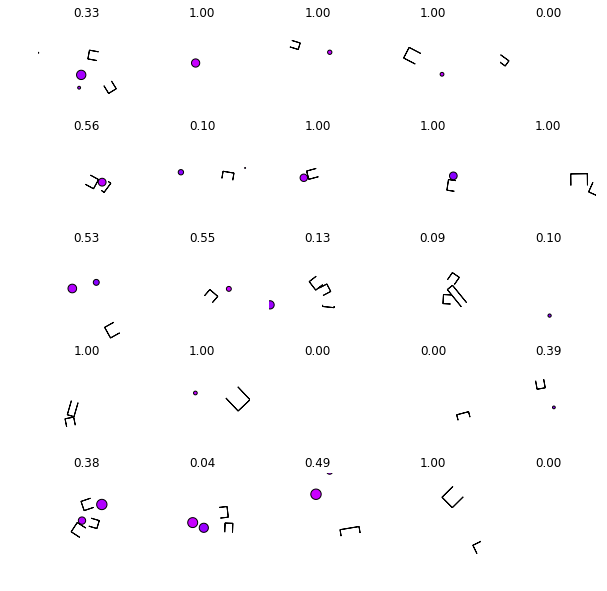

In [17]:
# Convert that data back to a YAML environment, which is easier to
# handle.
import scipy.stats
side_width = 5
generated_data, generated_encodings, generated_contexts = model.model()
scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
    generated_data)
plt.figure().set_size_inches(10, 10)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scene_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "planar_tabletop", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        plt.gca().set_title("%2.2f" % rvalue**2)

[3, 4, 2, 5, 4, 3, 2, 1, 5, 3, 3, 1, 4, 1, 3, 2, 3, 3, 1, 3, 4, 2, 2, 5, 3, 4, 2, 3, 2, 3, 3, 5, 4, 3, 3, 1, 3, 3, 2, 1, 4, 5, 4, 5, 4, 5, 3, 2, 3, 2, 4, 1, 5, 1, 2, 3, 3, 4, 3, 4, 2, 3, 3, 5, 3, 3, 5, 3, 2, 3, 5, 2, 5, 3, 2, 3, 4, 3, 4, 3, 2, 3, 1, 1, 3, 4, 4, 2, 4, 5, 2, 4, 2, 5, 3, 2, 5, 3, 4, 1, 3, 2, 1, 3, 1, 3, 2, 3, 3, 1, 2, 3, 1, 5, 3, 1, 4, 5, 2, 1, 4, 3, 1, 2, 2, 1, 3, 4, 2, 3, 3, 2, 1, 5, 5, 4, 3, 2, 2, 3, 1, 5, 2, 3, 4, 4, 2, 2, 1, 2, 4, 2, 2, 3, 4, 2, 5, 4, 4, 2, 3, 1, 5, 3, 3, 4, 2, 1, 2, 1, 4, 5, 4, 5, 2, 4, 3, 1, 5, 4, 3, 2, 3, 2, 4, 2, 3, 4, 5, 5, 3, 2, 4, 5, 2, 3, 1, 3, 4, 3, 2, 2, 5, 2, 3, 5, 1, 2, 1, 3, 5, 2, 5, 3, 3, 1, 2, 2, 5, 2, 2, 5, 5, 4, 5, 4, 4, 2, 3, 4, 3, 3, 3, 3, 1, 2, 5, 2, 3, 2, 4, 4, 3, 3, 3, 4, 4, 4, 1, 3, 4, 3, 4, 3, 3, 1, 2, 2, 5, 2, 3, 2, 3, 3, 2, 5, 4, 2, 2, 3, 1, 4, 4, 5, 2, 3, 4, 1, 2, 3, 1, 2, 2, 1, 2, 3, 5, 3, 2, 2, 2, 3, 3, 1, 2, 1, 5, 2, 3, 2, 1, 3, 4, 2, 2, 1, 2, 1, 3, 4, 2, 2, 3, 3, 3, 1, 3, 4, 3, 2, 2, 5, 1, 2, 3, 1, 5, 2, 1, 1, 4, 4, 2, 

Text(0,0.5,'Count')

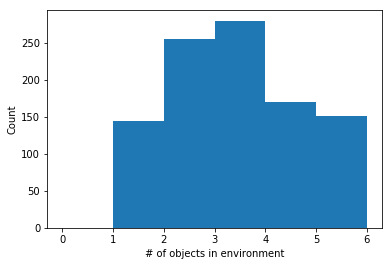

In [92]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    [generated_n_objs.append(scene["n_objects"]) for scene in scene_yaml]
print generated_n_objs
plt.hist(generated_n_objs, bins=range(7))
plt.xlabel("# of objects in environment")
plt.ylabel("Count")

In [15]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

# Generate some examples
scene_yaml = []
for k in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
params_by_object_class_nonpen = generate_params_by_object_class(scene_yaml)

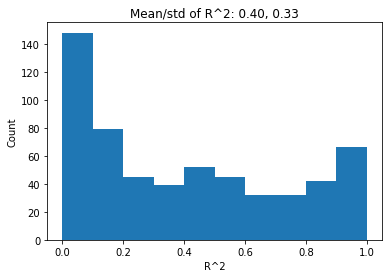

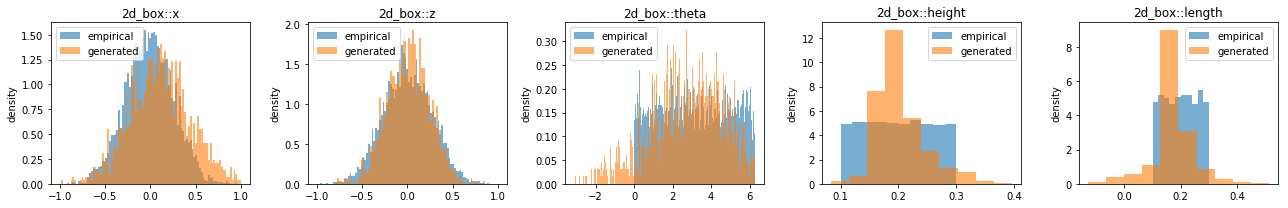

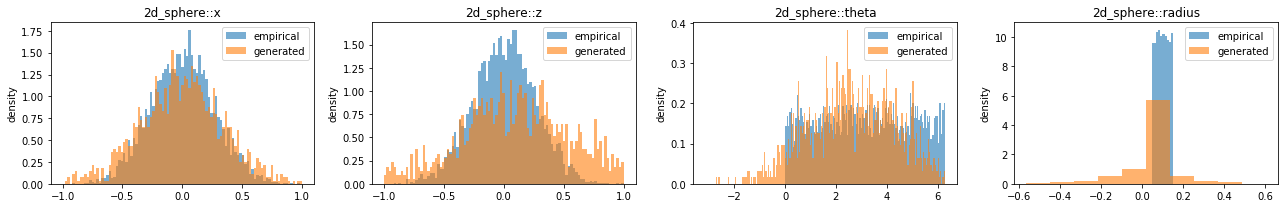

In [16]:
# Measure colinearity by doing a linear fit and reporting the error
import scipy.stats
rsquares = []
for scene in scene_yaml:
    if (scene["n_objects"] > 2):
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        rsquares.append(rvalue**2.)
plt.figure()
plt.hist(rsquares)
plt.ylabel("Count")
plt.xlabel("R^2")
plt.title("Mean/std of R^2: %2.2f, %2.2f" % (np.mean(rsquares), np.std(rsquares)))

for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        params_by_object_class_nonpen[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "generated"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(-1., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, 2*np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()

In [ ]:
# EXPORT
for k in range(50):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
    
import yaml
noalias_dumper = yaml.dumper.SafeDumper
noalias_dumper.ignore_aliases = lambda self, data: True

for env in scene_yaml:
    env_name = "env_%d" % int(round(time.time() * 1000))
    with open("generated_tabletop_lines_scenes_without_context_with_projection.yaml", "a") as file:
        yaml.dump({env_name:
                   env}, file, Dumper=noalias_dumper)

In [ ]:
# Probe what the guide is doing by, for a few test data examples,
from copy import deepcopy
subsample_inds = np.random.permutation(data_test.batch_size)
plt.figure().set_size_inches(10, 10)
N_examples = 5
for k in range(N_examples):
    plt.subplot(2, N_examples, k+1)
    data_test_subsample = data_test.subsample([subsample_inds[k]])
    generated_env = deepcopy(data_test_subsample.convert_to_yaml()[0])
    dataset_utils.DrawYamlEnvironmentPlanar(generated_env, "planar_tabletop", ax=plt.gca())
    plt.gca().set_title("BEFORE INV PROJ %d" % k)
    plt.subplot(2, N_examples, N_examples+k+1)
    for object_i in range(generated_env["n_objects"]):
        obj_yaml = generated_env["obj_%04d" % object_i]
        class_i = data_test_subsample.dataset.class_name_to_id[obj_yaml["class"]]
        new_params = model.class_guides[class_i](data_test_subsample.params_by_class[class_i][:, object_i, :])
        obj_yaml["pose"] = new_params[0, :3]
        obj_yaml["params"] = new_params[0, 3:]
    dataset_utils.DrawYamlEnvironmentPlanar(generated_env, "planar_tabletop", ax=plt.gca())
    plt.gca().set_title("AFTER INV PROJ %d" % k)